# Modeling single subject fMRI data using Generalized Linear Model(GLM)
*Created by Mengqiao Chai, Department of Experimental Psychology, Ghent University*

In this tutorial, you will be learning how to analyze fMRI data from a single subject using GLM. During the previous lectures of *H002006A - Analysis of Neuroimaging Data*, you already learned the foundations of brain signal analysis, such as convolution, design matrix, GLM etc. In this tutorial, you will learn how to combine these steps to actually analyze the fMRI data of one participant from a public data repository, such as [OSF](https://osf.io/) or [OpenNeuro](https://openneuro.org/). Please note that the development of this tutorial was heavily influenced by another great online tutorial:[DartBrains](https://dartbrains.org/content/intro.html). Please go to their website and browse through their materials for a more comprehensive explanation of fMRI analysis.



First of all, we need to import the packages that we will use later. the important one is [nltools](https://nltools.org/), which is a python package that facilitate fMRI analysis by flexibly leveragng on **nilearn** and **scikit learn**. So if you have not installed it yet, please use the command `!pip install nltools` in a notebook cell, or use the command `pip install nltools` directly in a Python Console.

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nilearn import image 
from nilearn.plotting import view_img, glass_brain, plot_stat_map

## Import and smooth the fMRI images
### A bit more information about the data
The example data was part of the dataset from the [DMCC](https://www.nature.com/articles/s41597-022-01226-4) project. In the dataset, 55 participants went through multiple sessions of anatomical and fMRI scanning sessions, in which they were asked to perform multiple classical cognitive tasks in multiple functional runs. In this tutorial, we will only use data of one functional run(*run-1*) from one participant (*sub-f1027ao*) when the participant were asked to perform a Stroop task in the scanner. The data was already preprocessed by using fmriprep.

Firstly, we load the 4D nifti images of this functional run from this particiapant:

In [2]:
data_dir = "/Users/mengqiao/Documents/Teaching/Analysis_NeuroImaging/example_data/DMCC55B/sub-f1027ao"
image_name = "sub-f1027ao_ses-wave1bas_task-Stroop_acq-mb4AP_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
image_path = os.path.join(data_dir, image_name)
image_4d = image.load_img(image_path)

Next, we examine the dimension of the data and define the number of TRs, which is also the number of volumes in this functional run, indicated by the 4th dimension of the data. We also define the length of TR, which can be identified from the .json sidecar file of any functional image.

In [3]:
print(image_4d.shape)
n_tr = image_4d.shape[3]
tr = 1.2

(81, 96, 81, 540)


Importantly, depends on the goal of our analysis, we need to decide if we want to spatially smooth our data or not. As the picture showed below, spatial smoothing will make the image more blurry. But why do we need to do this at all since it would reduce the image resolution? As we know, the fMRI images can be very noisy, thus by averaging the signals across neigboring voxel, we could increase the signal to noise ratio(SNR), thus increase the power of our analysis. And such smoothing has become a standard procedure in fMRI analysis, especially if we only want to examine univariate contrasts. On the other hand, if we aim to mainly conduct multivariate analyiss, such as neural decoding, typically we don't smooth the data because multivariate analysis was mainly used to catch very subtle spatial pattern differences between experimental condition.

In this tutorial, we will spatially smooth the data using 8 mm FWHM

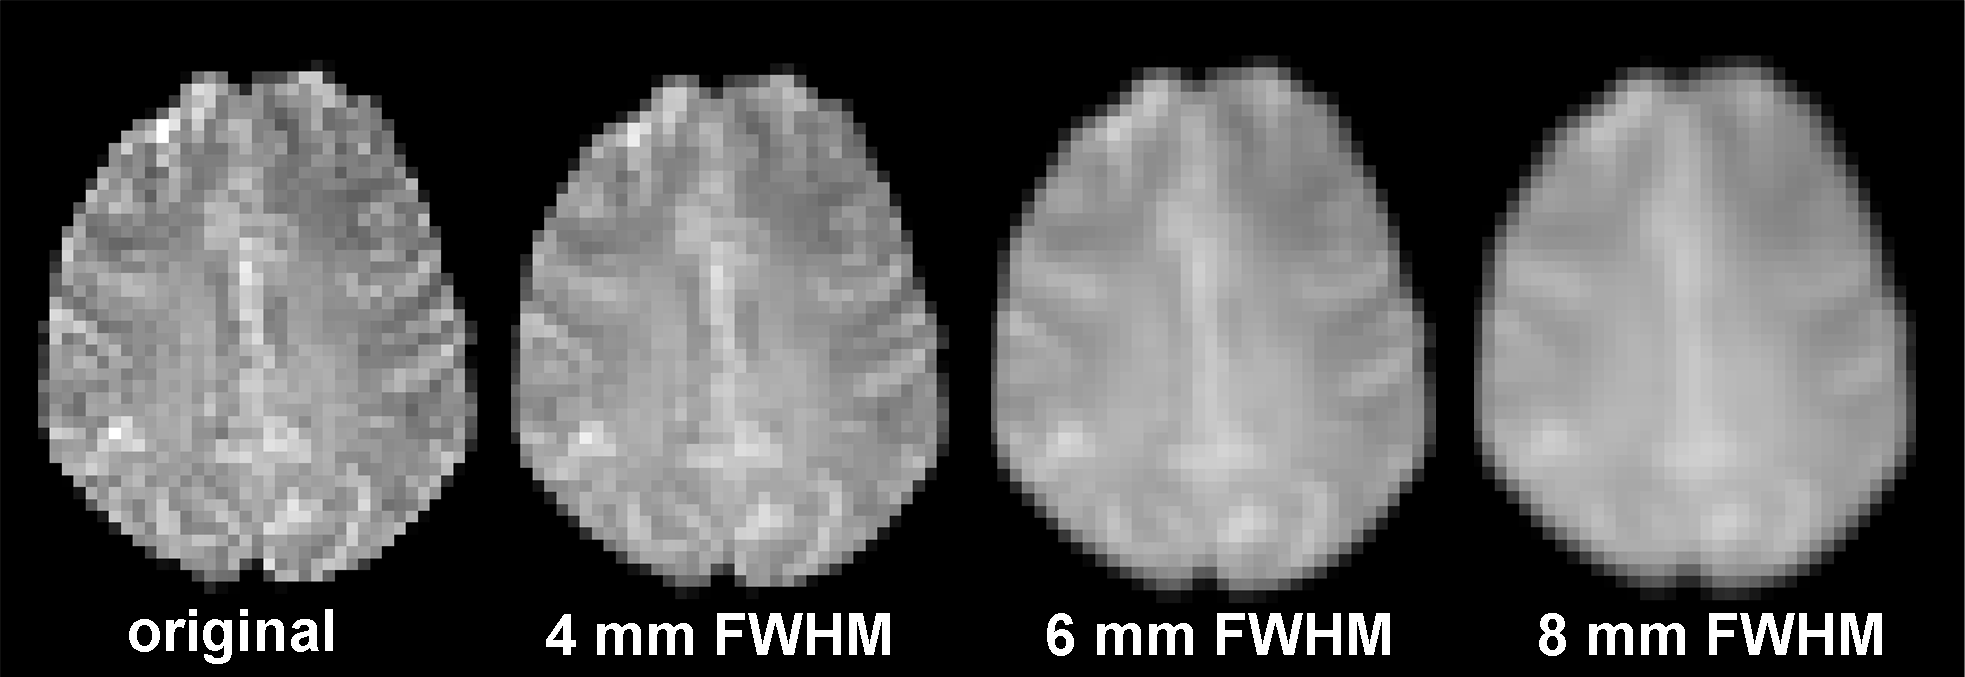

In [4]:
# Conducting the spatial smoothing on the fMRI images
data_image = Brain_Data(image_4d)

fwhm=8
data_image_smth = data_image.smooth(fwhm=fwhm) # the image after smoothing

/opt/anaconda3/envs/ni-edu/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


The smoothing could take a bit of time, let's patiently wait for awhile while it is runnning. After the smoothing is done, we can compare the images **Before** and **After** smoothing by visualizing the images

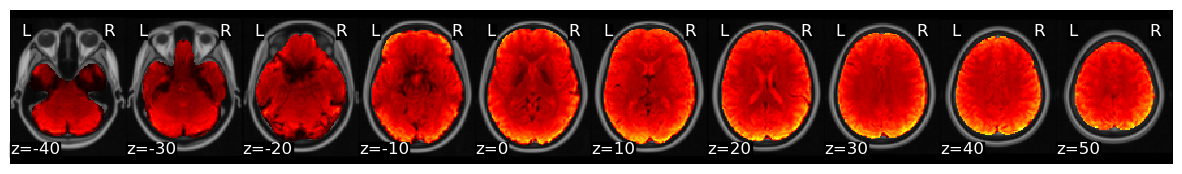

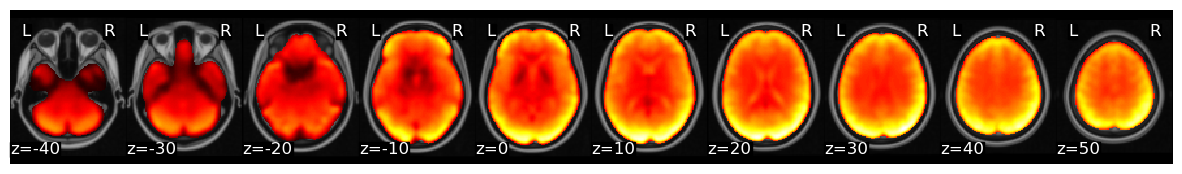

In [5]:
data_image.mean().plot()
data_image_smth.mean().plot()

Here you can tell that after smoothing, the resolution of the images decrease quite a lot!\
And since it take quite some time to smooth the images, it's a good idea to save these smoothed images so we don't need to do it every time!

In [25]:
image_smth_name = 'smth8' + image_name
data_image_smth.write(os.path.join(data_dir, image_smth_name))

## Load the event file and create the design matrix
For the next step, we need to load the event file that was created while we acquired above images. This event file(normally as an .tsv file in the BIDS format) contained important information that we need to use to model our fMRI data with. Typically, we need these three information for the fMRI data modeling:
1. the experimental condition
2. the event onset
3. the event duration

The **experimental condition** defines the condition we are interested in for each trial, in this Stroop task, the condition can be either congruent ("Con") or incongruent ("InCon"). **the event onset** specifies the onset time of the stimulus relative to the start of the scanning session. And **the event duration** measures how long the event (i.e. the Stroop stimulus) last. All the timing related variables are measured in second(s). 

First, we need to load the event file, which is normally a .tsv file based on the BIDS format. And we only include the information we need for the subquent GLM.

In [6]:
event_file_name = "sub-f1027ao_ses-wave1bas_task-Stroop_acq-mb4AP_run-1_events.tsv"
event_file_path = os.path.join(data_dir, event_file_name)
event_file_df  = pd.read_csv(event_file_path, sep="\t")
display(event_file_df)

,onset,duration,trial_type,trial_lwpc,response_time,response_accuracy
0,30.706,2,Con,MC,0.6615,1
1,36.706,2,InCon,MC,0.8605,0
2,41.506,2,InCon,PC50,0.6775,1
3,47.505,2,Con,PC50,0.6900,1
4,52.305,2,Con,PC50,0.7210,1
...,...,...,...,...,...,...
103,586.313,2,InCon,PC50,0.6565,1
104,589.912,2,Con,MC,0.7140,1
105,594.712,2,InCon,PC50,0.6110,1
106,599.511,2,Con,PC50,0.7050,1


As shown above, the first 3 columns are the information we need typically for the GLM. In this particular example, since the stimuli were presented relatively short and with the same length across trials, we only model the event onset without duration in the GLM. In addition, we will only model the trials that participants responded correctly, as follows:

In [7]:
events = (event_file_df
          .query('response_accuracy == 1')
          .loc[:,['onset', 'trial_type']]
          .rename(columns={"onset": "Onset", "trial_type": "Stim"})
          )

And then we create the design matrix using these information. For constructing the design matrix, we will be using a function(*onsets_to_dm*) from nltools to help us do that. In addtion to the event related information, we also need to specify the sampling frequency (*sampling_freq*), which is the reciprocal for TR, as well as the number of scans we acquired in this run (*run_length*)

In [8]:
design_mat = onsets_to_dm(events, sampling_freq=1/tr, run_length=n_tr)
design_mat.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Con     540 non-null    float64
 1   InCon   540 non-null    float64
dtypes: float64(2)
memory usage: 8.6 KB


/opt/anaconda3/envs/ni-edu/lib/python3.9/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  warnings.warn(


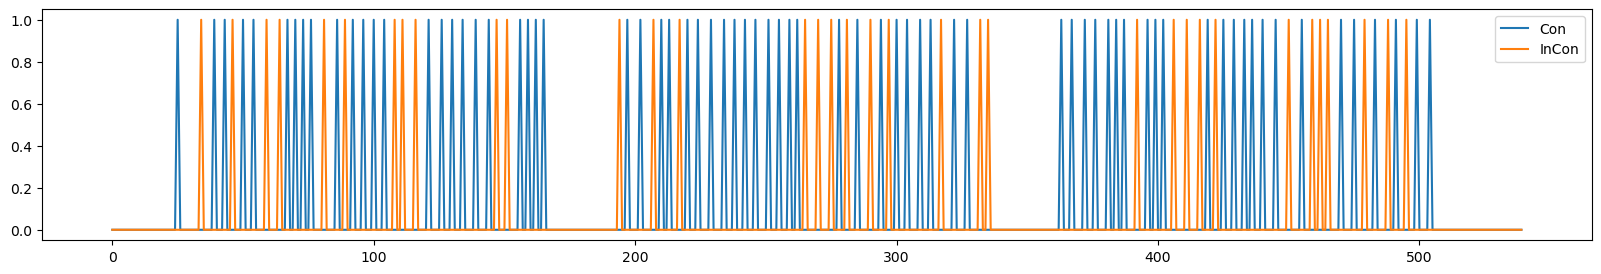

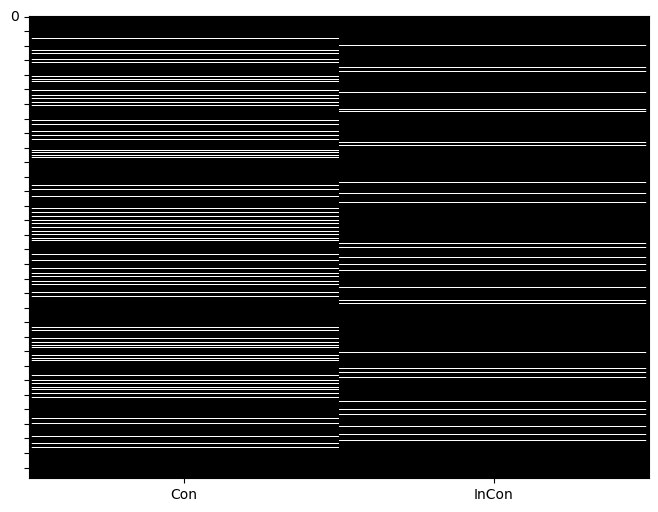

In [9]:
# Let's visualize the design matrix
f,a = plt.subplots(figsize=(20,3))
design_mat.plot(ax=a) # show the onset of two conditions together across the scans
design_mat.heatmap()  # show the onset of two conditions separately side by side

For the next step, which is also an important step, we need to convolve the event onset with [canonical HRF](https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/Statistics/03_Stats_HRF_Overview.html). If you are not sure why we need to do this or you are interested in the techinical details of it, please refer to 3 other notebooks : 

- hrf_tutorial.ipynb
- step_by_step_convolution.ipynb,
- fMRI_convolution.ipynb

In [11]:
design_mat_conv = design_mat.convolve()

<Axes: >

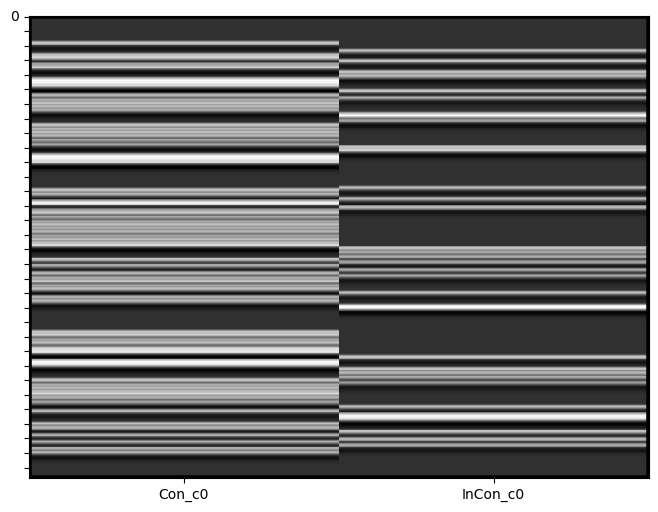

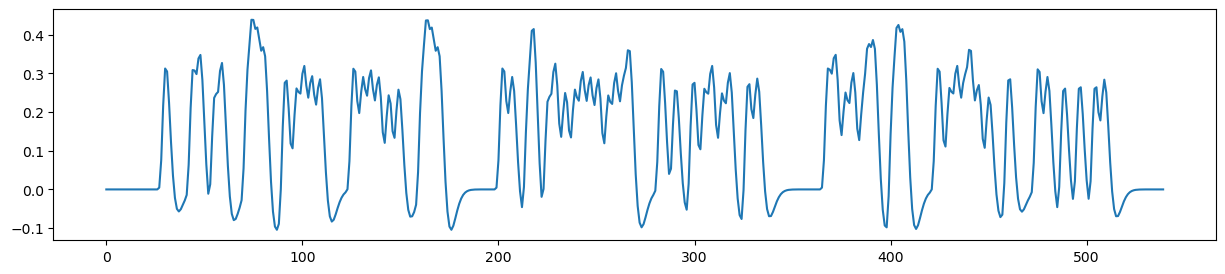

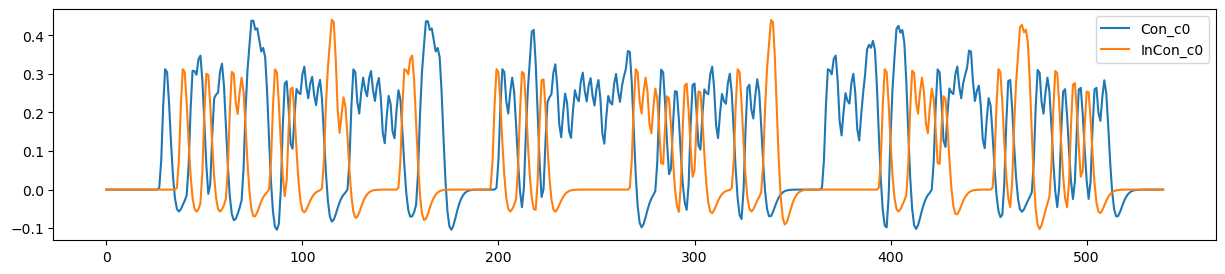

In [12]:
# Let's visualize the convolution result
design_mat_conv.heatmap() # Convolved onsets separately for each condition

f,a = plt.subplots(figsize=(15,3))
design_mat_conv['Con_c0'].plot(ax=a) # Convolved onsets only for congruent condition

f,a = plt.subplots(figsize=(15,3))
design_mat_conv[['Con_c0','InCon_c0']].plot(ax=a) # Convolved onsets for both congruent and incongruent condition

Like all the linear models, we normally include a intercept to account for the baseline activity throughout the whole run.

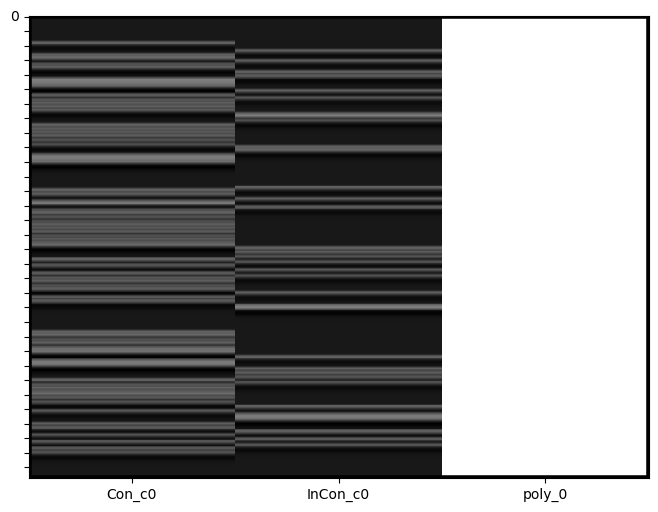

In [13]:
# Add intercept regressor
design_mat_conv_poly = design_mat_conv.add_poly()
design_mat_conv_poly.heatmap()

## Include the motion regressors into the design matrix
In fMRI data analysis, one of the most prominent confounding factors is participants' movement in the scanner, which is why we want to include motion related variables in the GLM to account for motion related variance in the fMRI data. Thanks to fmriprep, we can easily have access to these information since they are part of standard output from the fmriprep pipeline, indicated by the suffix "desc-confounds_regressors.tsv" in the preprocess data.

In [14]:
# import the confound regressors file
nuis_file_name = "sub-f1027ao_ses-wave1bas_task-Stroop_acq-mb4AP_run-1_desc-confounds_regressors.tsv"
nuis_file_path = os.path.join(data_dir, nuis_file_name)
nuis_file_df  = pd.read_csv(nuis_file_path, sep="\t")

In [15]:
# let's see what kind of data it contains
nuis_file_df.columns

Index(['csf', 'white_matter', 'global_signal', 'std_dvars', 'dvars',
       'framewise_displacement', 't_comp_cor_00', 't_comp_cor_01',
       't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05',
       'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
       'a_comp_cor_04', 'a_comp_cor_05', 'cosine00', 'cosine01', 'cosine02',
       'cosine03', 'cosine04', 'cosine05', 'cosine06', 'cosine07', 'cosine08',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'],
      dtype='object')

As showed above, this file contains various variables that can be included as confounding regressors (oftentimes called nuisance regressors in fMRI analysis). for our illustration purpose, we only include 6 motion related regressors ('trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z') in the GLM. Addtionally, we will standardize (i.e. z-score) theses regressors to facilitate the upcoming model-fitting process.

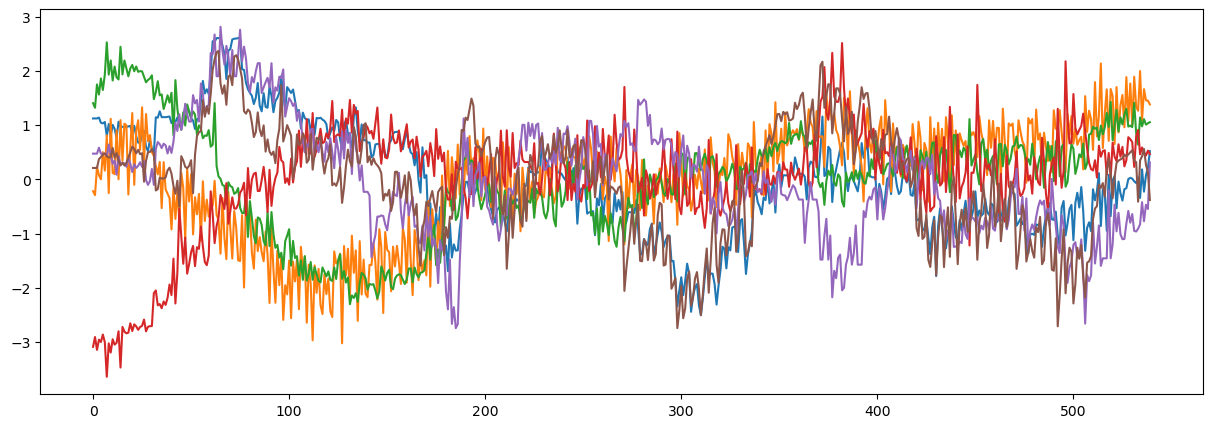

In [16]:
mot_regs = nuis_file_df[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mot_regs_std = zscore(mot_regs)

# Let's visualize the result
plt.figure(figsize=(15,5))
plt.plot(mot_regs_std)

The last step before model fitting is to create the full design matrix by concatenating the event regressors and the nuisance regressors.

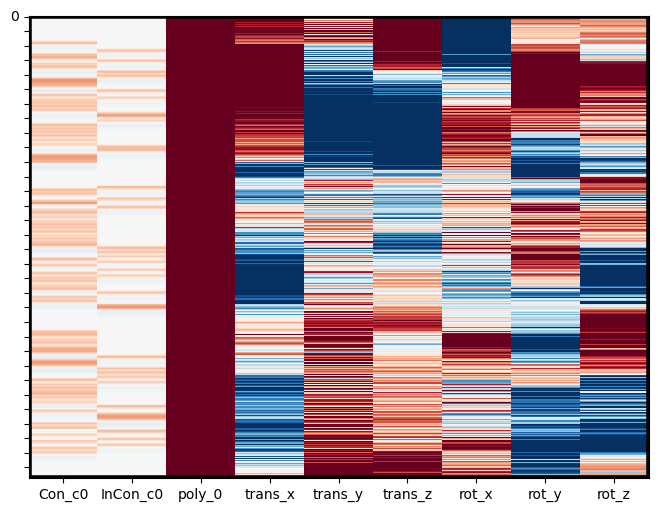

In [17]:
# design matrix of nuissance regressors
design_mat_nuis = Design_Matrix(mot_regs_std, sampling_freq=1/tr)

# concatenate the event design matrix with the nuissance matrix
design_mat_full = pd.concat([design_mat_conv_poly, design_mat_nuis], axis=1)
design_mat_full.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

<div class="alert alert-info"><b>Extra thinking:</b> <p>Have you noticed that we did not convolve the nuissance regressors with the canonical HRF? Can you think about why did we not do that ?</p></div>

## GLM model fitting
Finally, now we can fit our fMRI data to the design matrix we just created. By using **nltools**, this is very easy, we only need to specify the *.X* attribute of the smoothed images and use the *.regress()* method to fit the data uing GLM.

In [18]:
data_image_smth.X = design_mat_full
results_flm = data_image_smth.regress()

In [19]:
# Let's check out the structure of the modeling result
print(results_flm.keys()) # the estimates for all the predictors
print(data_image_smth.X.columns) # all the predictors included in the model, you should be able to recognize them

dict_keys(['beta', 't', 'p', 'df', 'sigma', 'residual'])
Index(['Con_c0', 'InCon_c0', 'poly_0', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z'],
      dtype='object')


<div class="alert alert-info"><b>To do:</b> <p>Here, we only model the data from one functional run of the Stroop task. But actually, for each participant, there are 2 functional runs of Stroop task. Thus, can you model the data from these 2 runs together? In order to do so, you need to download and import the data from the second run, and concatenate both the images and the design matrices, please check out <a href="https://nltools.org/auto_examples/01_DataOperations/plot_design_matrix.html">this page</a> to learn more about how to do that.</p><p> Good luck !</p></div>

# Creating univariate contrasts
In fMRI analysis, we always need to compare different conditions, thus we need to constrct contrasts between conditions of interest. In this Stroop task, we are interested in the contrast between incongruent and congruent condition, especially we want to see which brain regions respond stronger to incongruent condition compared to congruent condition. To do so, we assign 1 to the Incongruent predictor and -1 to the congruent predictor, and we can plot this contrast image to see the result

In [26]:
# first we need to see which predictors we want to contrast
print(data_image_smth.X.columns)

# defining the contrast
c1 = np.zeros(len(results_flm['beta']))
c1[[0]] = -1
c1[[1]] = 1
print(c1)

Index(['Con_c0', 'InCon_c0', 'poly_0', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z'],
      dtype='object')
[-1.  1.  0.  0.  0.  0.  0.  0.  0.]


In [27]:
# applying the contrast and plot the result
control = results_flm['beta'] * c1
control.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

So which regions do you see that show hightened activity for incongruent condition? does the result make sense to you ?